In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [3]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [5]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [6]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [7]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

In [10]:
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [15]:
weights = y_train_enc
weights = np.choose(weights, [0.8, 1, 0.8])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.  1.  0.8 ... 1.  1.  1. ] 

Ini y_train_encode
 [1 1 0 ... 1 1 1] 



In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 4
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.33647	test-merror:0.37437
[1]	train-merror:0.29844	test-merror:0.32412
[2]	train-merror:0.27589	test-merror:0.33668
[3]	train-merror:0.26091	test-merror:0.30653
[4]	train-merror:0.26161	test-merror:0.32161
[5]	train-merror:0.24790	test-merror:0.29900
[6]	train-merror:0.24752	test-merror:0.29648
[7]	train-merror:0.24417	test-merror:0.28392
[8]	train-merror:0.23552	test-merror:0.28643
[9]	train-merror:0.23438	test-merror:0.29146
[10]	train-merror:0.23318	test-merror:0.29397
[11]	train-merror:0.23116	test-merror:0.29397
[12]	train-merror:0.23141	test-merror:0.28895
[13]	train-merror:0.23084	test-merror:0.29146
[14]	train-merror:0.22951	test-merror:0.28895
[15]	train-merror:0.22787	test-merror:0.29648
[16]	train-merror:0.22920	test-merror:0.29146
[17]	train-merror:0.22699	test-merror:0.28895
[18]	train-merror:0.22762	test-merror:0.29146
[19]	train-merror:0.22503	test-merror:0.29648
[20]	train-merror:0.22794	test-merror:0.30653
[21]	train-merror:0.22478	test-merror:0.3090

[177]	train-merror:0.17872	test-merror:0.27638
[178]	train-merror:0.17733	test-merror:0.27638
[179]	train-merror:0.17790	test-merror:0.27638
[180]	train-merror:0.17758	test-merror:0.27638
[181]	train-merror:0.17765	test-merror:0.27638
[182]	train-merror:0.17765	test-merror:0.27638
[183]	train-merror:0.17683	test-merror:0.27638
[184]	train-merror:0.17689	test-merror:0.27638
[185]	train-merror:0.17765	test-merror:0.27638
[186]	train-merror:0.17714	test-merror:0.27889
[187]	train-merror:0.17689	test-merror:0.27889
[188]	train-merror:0.17664	test-merror:0.27638
[189]	train-merror:0.17632	test-merror:0.27638
[190]	train-merror:0.17638	test-merror:0.27889
[191]	train-merror:0.17480	test-merror:0.27638
[192]	train-merror:0.17537	test-merror:0.27638
[193]	train-merror:0.17500	test-merror:0.27889
[194]	train-merror:0.17443	test-merror:0.27889
[195]	train-merror:0.17361	test-merror:0.27889
[196]	train-merror:0.17203	test-merror:0.27889
[197]	train-merror:0.17247	test-merror:0.27638
[198]	train-m

[352]	train-merror:0.14107	test-merror:0.26884
[353]	train-merror:0.14259	test-merror:0.26884
[354]	train-merror:0.14164	test-merror:0.26884
[355]	train-merror:0.14056	test-merror:0.26884
[356]	train-merror:0.14050	test-merror:0.26884
[357]	train-merror:0.13936	test-merror:0.26884
[358]	train-merror:0.13880	test-merror:0.26884
[359]	train-merror:0.13886	test-merror:0.26884
[360]	train-merror:0.13911	test-merror:0.26884
[361]	train-merror:0.13968	test-merror:0.26884
[362]	train-merror:0.13962	test-merror:0.26884
[363]	train-merror:0.13880	test-merror:0.26884
[364]	train-merror:0.13880	test-merror:0.26884
[365]	train-merror:0.13880	test-merror:0.26884
[366]	train-merror:0.13823	test-merror:0.26884
[367]	train-merror:0.13848	test-merror:0.26884
[368]	train-merror:0.13873	test-merror:0.26884
[369]	train-merror:0.13854	test-merror:0.26884
[370]	train-merror:0.13778	test-merror:0.26884
[371]	train-merror:0.13753	test-merror:0.26884
[372]	train-merror:0.13747	test-merror:0.26884
[373]	train-m

[527]	train-merror:0.11296	test-merror:0.26633
[528]	train-merror:0.11346	test-merror:0.26633
[529]	train-merror:0.11321	test-merror:0.26633
[530]	train-merror:0.11296	test-merror:0.26633
[531]	train-merror:0.11353	test-merror:0.26633
[532]	train-merror:0.11270	test-merror:0.26633
[533]	train-merror:0.11245	test-merror:0.26633
[534]	train-merror:0.11207	test-merror:0.26633
[535]	train-merror:0.11188	test-merror:0.26633
[536]	train-merror:0.11188	test-merror:0.26633
[537]	train-merror:0.11138	test-merror:0.26633
[538]	train-merror:0.11138	test-merror:0.26633
[539]	train-merror:0.11220	test-merror:0.26382
[540]	train-merror:0.11188	test-merror:0.26382
[541]	train-merror:0.11220	test-merror:0.26382
[542]	train-merror:0.11163	test-merror:0.26633
[543]	train-merror:0.11144	test-merror:0.26633
[544]	train-merror:0.11195	test-merror:0.26633
[545]	train-merror:0.11138	test-merror:0.26382
[546]	train-merror:0.11163	test-merror:0.26633
[547]	train-merror:0.11081	test-merror:0.26633
[548]	train-m

[702]	train-merror:0.09167	test-merror:0.26131
[703]	train-merror:0.09110	test-merror:0.25879
[704]	train-merror:0.09192	test-merror:0.26131
[705]	train-merror:0.09173	test-merror:0.26131
[706]	train-merror:0.09028	test-merror:0.26131
[707]	train-merror:0.09059	test-merror:0.25879
[708]	train-merror:0.09091	test-merror:0.25879
[709]	train-merror:0.09091	test-merror:0.26131
[710]	train-merror:0.09091	test-merror:0.25879
[711]	train-merror:0.09091	test-merror:0.26131
[712]	train-merror:0.09040	test-merror:0.26131
[713]	train-merror:0.09059	test-merror:0.26131
[714]	train-merror:0.09034	test-merror:0.25879
[715]	train-merror:0.08983	test-merror:0.25879
[716]	train-merror:0.08895	test-merror:0.26131
[717]	train-merror:0.08946	test-merror:0.26131
[718]	train-merror:0.08983	test-merror:0.26131
[719]	train-merror:0.08920	test-merror:0.26131
[720]	train-merror:0.08946	test-merror:0.26131
[721]	train-merror:0.08952	test-merror:0.26131
[722]	train-merror:0.09009	test-merror:0.26131
[723]	train-m

[877]	train-merror:0.06981	test-merror:0.26382
[878]	train-merror:0.07044	test-merror:0.26382
[879]	train-merror:0.06956	test-merror:0.26382
[880]	train-merror:0.07012	test-merror:0.26382
[881]	train-merror:0.06987	test-merror:0.26633
[882]	train-merror:0.06987	test-merror:0.26382
[883]	train-merror:0.06956	test-merror:0.26382
[884]	train-merror:0.06962	test-merror:0.26382
[885]	train-merror:0.06962	test-merror:0.26633
[886]	train-merror:0.06962	test-merror:0.26382
[887]	train-merror:0.06937	test-merror:0.26633
[888]	train-merror:0.06930	test-merror:0.26633
[889]	train-merror:0.06899	test-merror:0.26382
[890]	train-merror:0.06873	test-merror:0.26382
[891]	train-merror:0.06899	test-merror:0.26382
[892]	train-merror:0.06899	test-merror:0.26382
[893]	train-merror:0.06873	test-merror:0.26382
[894]	train-merror:0.06873	test-merror:0.26382
[895]	train-merror:0.06817	test-merror:0.26382
[896]	train-merror:0.06791	test-merror:0.26382
[897]	train-merror:0.06791	test-merror:0.26382
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7386934673366834 

Train Score
 0.9435702658708627 

CONFUSSION MATRIX
 [[ 19   4  43]
 [  6   5  11]
 [ 27  13 270]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.37      0.29      0.32        66
      netral       0.23      0.23      0.23        22
     positif       0.83      0.87      0.85       310

    accuracy                           0.74       398
   macro avg       0.48      0.46      0.47       398
weighted avg       0.72      0.74      0.73       398
 



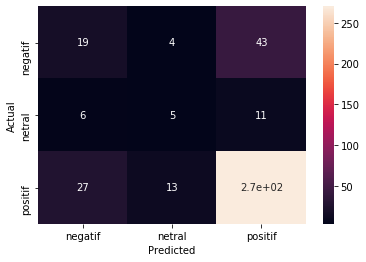

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])